Data Preprocessing 

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

# === Step 1: Read Excel with selected columns ===
cols_to_read = [
    'LOCATION', 'ROOM', 'CASE_STATUS', 'OPERATION_TYPE', 'EMERGENCY_PRIORITY',
    'SURGICAL_CODE', 'DISCIPLINE', 'SURGEON', 'ANAESTHETIST_TEAM',
    'ANESTHESIA', 'EQUIPMENT', 'ADMISSION_STATUS', 'ADMISSION_CLASS_TYPE', 'ADMISSION_TYPE',
    'ADMISSION_WARD', 'ADMISSION_BED', 'AOH', 'BLOOD', 'IMPLANT', 'DIAGNOSIS',
    'CANCER_INDICATOR', 'TRAUMA_INDICATOR',
    'DIFF_SURGERY_DURATION', 'DIFF_USAGE_DURATION'
]

df = pd.read_excel("Final_Cleaned_Dataset_OPTIC_7.xlsx", usecols=cols_to_read)

In [2]:
# === Step 1a: Outlier Filtering ===
def remove_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr # can adjust multiplier
    upper = q3 + 1.5 * iqr # can adjust multiplier
    return series.between(lower, upper)

n_before = len(df)

mask_surg = remove_outliers_iqr(df['DIFF_SURGERY_DURATION'])
mask_usage = remove_outliers_iqr(df['DIFF_USAGE_DURATION'])
df = df[mask_surg & mask_usage]

n_after = len(df)
n_removed = n_before - n_after
pct_removed = (n_removed / n_before) * 100

print(f"Rows removed: {n_removed}")
print(f"Percentage removed: {pct_removed:.2f}%")

Rows removed: 37040
Percentage removed: 14.89%


In [3]:
# === Step 2: Clean / preprocess columns ===
df['EMERGENCY_PRIORITY'].replace("0", np.nan, inplace=True)
df['EQUIPMENT'].replace("0", np.nan, inplace=True)
df['IMPLANT'].replace("0", np.nan, inplace=True)
df['DIAGNOSIS'].replace("not recorded", np.nan, inplace=True)

df['BLOOD'] = df['BLOOD'].apply(lambda x: False if str(x).strip().upper() == 'NIL' else True)

def categorize_text(text):
    if pd.isna(text):
        return 'Unknown'
    text = str(text).lower()
    if 'cancer' in text or 'ca' in text:
        return 'Cancer'
    if 'stone' in text:
        return 'Gallstone/Kidney'
    if 'rupture' in text or 'tear' in text:
        return 'Trauma'
    if 'pregnancy' in text:
        return 'Pregnancy'
    if 'hydrocephalus' in text:
        return 'Neuro'
    if 'subfert' in text:
        return 'Fertility'
    return 'Other'

df['IMPLANT_CAT'] = df['IMPLANT'].apply(categorize_text)
df['DIAGNOSIS_CAT'] = df['DIAGNOSIS'].apply(categorize_text)

# === Step 3: Feature Engineering ===
categorical_cols = [
    'LOCATION', 'ROOM', 'CASE_STATUS', 'OPERATION_TYPE', 'EMERGENCY_PRIORITY',
    'DISCIPLINE', 'SURGEON', 'ANAESTHETIST_TEAM',
    'ANESTHESIA', 'EQUIPMENT', 'ADMISSION_STATUS', 'ADMISSION_CLASS_TYPE',
    'ADMISSION_TYPE', 'ADMISSION_WARD', 'ADMISSION_BED', 'IMPLANT_CAT', 'DIAGNOSIS_CAT'
]

for col in categorical_cols:
    df[col] = df[col].astype(str)

bool_cols = ['AOH', 'BLOOD', 'CANCER_INDICATOR', 'TRAUMA_INDICATOR']

# Dependent variables
y = df[['DIFF_SURGERY_DURATION', 'DIFF_USAGE_DURATION']]
surgical_code_df = df[['SURGICAL_CODE']]
X_raw = df[categorical_cols + bool_cols]

# === Step 4: Define Custom Transformers ===
class SurgicalCodeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mlb = MultiLabelBinarizer(sparse_output=True)
        self.mlb.fit(X['SURGICAL_CODE'].fillna('').apply(self._split_codes))
        return self

    def transform(self, X):
        return self.mlb.transform(X['SURGICAL_CODE'].fillna('').apply(self._split_codes))

    def _split_codes(self, val):
        return [code.strip() for code in str(val).split(';') if code.strip()]

class EquipmentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mlb = MultiLabelBinarizer(sparse_output=True)
        self.mlb.fit(X['EQUIPMENT'].fillna('').apply(self._split_equipment))
        return self

    def transform(self, X):
        return self.mlb.transform(X['EQUIPMENT'].fillna('').apply(self._split_equipment))

    def _split_equipment(self, val):
        return [item.strip().lower() for item in str(val).split(';') if item.strip()]

# --- In ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols),
        ('bool', 'passthrough', bool_cols)
    ],
    sparse_threshold=0.0  # Force sparse output overall
)

# --- New FeatureCombinerSparse ---
class FeatureCombinerSparse(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.surgical = SurgicalCodeTransformer()
        self.equipment = EquipmentTransformer()
        self.preprocessor = preprocessor

    def fit(self, X, y=None):
        X_main, X_surg, X_equipment = X
        self.surgical.fit(X_surg)
        self.equipment.fit(X_equipment)
        self.preprocessor.fit(X_main)
        return self

    def transform(self, X):
        X_main, X_surg, X_equipment = X

        X_main_proc = self.preprocessor.transform(X_main)  # sparse matrix

        # Split cat and bool features
        n_bool = len(bool_cols)
        if n_bool > 0:
            cat_data = X_main_proc[:, :-n_bool]
            bool_data = X_main_proc[:, -n_bool:]
            if not sparse.issparse(bool_data):
                bool_data = sparse.csr_matrix(bool_data)
        else:
            cat_data = X_main_proc
            bool_data = sparse.csr_matrix((X_main_proc.shape[0], 0))

        X_surg_sparse = self.surgical.transform(X_surg)
        X_equipment_sparse = self.equipment.transform(X_equipment)

        X_combined = sparse.hstack([cat_data, bool_data, X_surg_sparse, X_equipment_sparse]).tocsr()

        return X_combined

In [4]:
# Generalisable Helper Function
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def plot_residual_diagnostics(y_true, y_pred, title_prefix="Model"):
    """
    Generates residual diagnostic plots:
    - Residuals vs Fitted
    - QQ Plot of residuals
    """
    residuals = y_true - y_pred

    # --- Residuals vs Fitted ---
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.xlabel("Fitted Values (Predicted)")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # --- QQ Plot ---
    sm.qqplot(residuals, line='45', fit=True)
    plt.title(f"{title_prefix}: QQ Plot of Residuals")
    plt.tight_layout()
    plt.show()

def plot_residuals_vs_feature(X, residuals, feature_name, target_name, n_categories=20):
    """
    Residuals vs single feature.
    Handles numeric or categorical predictors.
    """
    feature = X[feature_name]

    plt.figure(figsize=(6, 4))
    if pd.api.types.is_numeric_dtype(feature):
        sns.scatterplot(x=feature, y=residuals, alpha=0.6)
    else:
        # Collapse rare categories for readability
        counts = feature.value_counts().nlargest(n_categories).index
        filtered = feature.where(feature.isin(counts), other="Other")
        sns.boxplot(x=filtered, y=residuals)
        plt.xticks(rotation=45)

    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals vs {feature_name} ({target_name})")
    plt.xlabel(feature_name)
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

Performance on Differences<br>
Method: Random Forest

Exclude 1.5 * IQR Outliers<br>
Rows removed: 37040<br>
Percentage removed: 14.89%<br>
MAE (DIFF_SURGERY_DURATION): 13.020701542043252<br>
MAE (DIFF_USAGE_DURATION): 15.391510712546618

In [5]:
# === Part 2: Predict ACTUAL_SURGERY_DURATION and ACTUAL_USAGE_DURATION with HistGradientBoostingRegressor ===

# Outcomes
y_actual = df[['DIFF_SURGERY_DURATION', 'DIFF_USAGE_DURATION']]

# Train/test split (same random_state to align)
X_train_raw, X_test_raw, surg_train, surg_test, equip_train, equip_test, y_train, y_test = train_test_split(
    X_raw, surgical_code_df, df[['EQUIPMENT']], y_actual, test_size=0.2, random_state=42
)

# Step 1: OneHotEncode categorical columns, sparse=True
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
ohe.fit(X_train_raw[categorical_cols])
X_train_cat_sparse = ohe.transform(X_train_raw[categorical_cols])
X_test_cat_sparse = ohe.transform(X_test_raw[categorical_cols])

print(type(X_train_cat_sparse))
print(sparse.issparse(X_train_cat_sparse))

# Step 2: Convert bool columns to sparse
def bool_to_sparse(df_bool):
    return sparse.csr_matrix(df_bool.values)

X_train_bool_sparse = bool_to_sparse(X_train_raw[bool_cols])
X_test_bool_sparse = bool_to_sparse(X_test_raw[bool_cols])

print(type(X_train_bool_sparse))
print(sparse.issparse(X_train_bool_sparse))

# Step 3: Transform surgical code and equipment with your transformers (make sure they output sparse matrices)
surgical_transformer = SurgicalCodeTransformer()
equipment_transformer = EquipmentTransformer()

surgical_transformer.fit(surg_train)
equipment_transformer.fit(equip_train)

X_train_surg_sparse = surgical_transformer.transform(surg_train)
X_test_surg_sparse = surgical_transformer.transform(surg_test)

print(type(X_train_surg_sparse))
print(sparse.issparse(X_train_surg_sparse))

X_train_equip_sparse = equipment_transformer.transform(equip_train)
X_test_equip_sparse = equipment_transformer.transform(equip_test)

# Step 4: Horizontally stack all sparse features
X_train_combined = sparse.hstack([X_train_cat_sparse, X_train_bool_sparse, X_train_surg_sparse, X_train_equip_sparse]).tocsr()
X_test_combined = sparse.hstack([X_test_cat_sparse, X_test_bool_sparse, X_test_surg_sparse, X_test_equip_sparse]).tocsr()

print(type(X_train_combined))
print(sparse.issparse(X_train_combined))

print("Train combined shape:", X_train_combined.shape)
print("Sparse?", sparse.issparse(X_train_combined))

rf_surg = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_surg.fit(X_train_combined, y_train['DIFF_SURGERY_DURATION'])
y_pred_surg = rf_surg.predict(X_test_combined)

# Evaluate
mae_surg_actual = mean_absolute_error(y_test['DIFF_SURGERY_DURATION'], y_pred_surg)

print("MAE (DIFF_SURGERY_DURATION):", mae_surg_actual)

<class 'scipy.sparse._csr.csr_matrix'>
True
<class 'scipy.sparse._csr.csr_matrix'>
True
<class 'scipy.sparse._csr.csr_matrix'>
True
<class 'scipy.sparse._csr.csr_matrix'>
True
Train combined shape: (169395, 23557)
Sparse? True
MAE (DIFF_SURGERY_DURATION): 13.020701542043252


In [6]:
rf_usage = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_usage.fit(X_train_combined, y_train['DIFF_USAGE_DURATION'])
y_pred_usage = rf_usage.predict(X_test_combined)

# Evaluate
mae_usage_actual = mean_absolute_error(y_test['DIFF_USAGE_DURATION'], y_pred_usage)

print("MAE (DIFF_USAGE_DURATION):", mae_usage_actual)

MAE (DIFF_USAGE_DURATION): 15.391510712546618


In [ ]:
# # Save results
# with open("diff_random_forest.txt", "w") as f:
#     f.write(f"MAE (ACTUAL_SURGERY_DURATION): {mae_surg_actual}\n")
#     f.write(f"MAE (ACTUAL_USAGE_DURATION): {mae_usage_actual}\n\n")

#     f.write("ACTUAL_SURGERY_DURATION = {:.6f}".format(glm_surg.intercept_))
#     for coef, name in zip(glm_surg.coef_, all_feature_names):
#         f.write(f" + ({coef:.6f} * {name})")
#     f.write("\n\n")

#     f.write("ACTUAL_USAGE_DURATION = {:.6f}".format(glm_usage.intercept_))
#     for coef, name in zip(glm_usage.coef_, all_feature_names):
#         f.write(f" + ({coef:.6f} * {name})")
#     f.write("\n")

Visualise Residuals

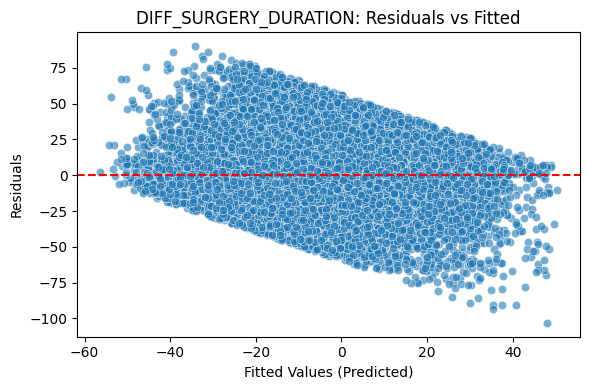

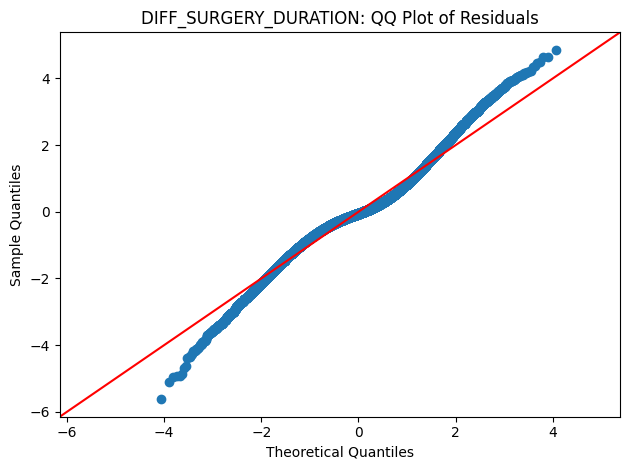

In [8]:
plot_residual_diagnostics(y_test['DIFF_SURGERY_DURATION'], y_pred_surg, "DIFF_SURGERY_DURATION")

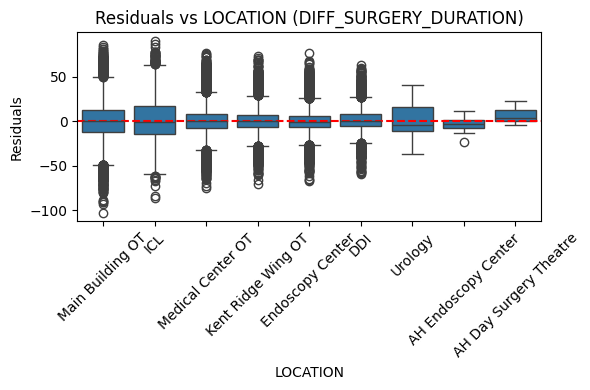

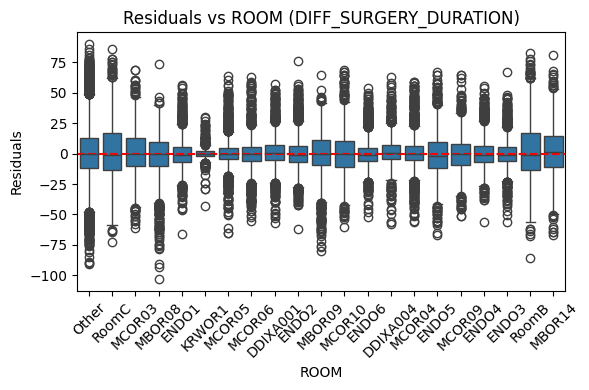

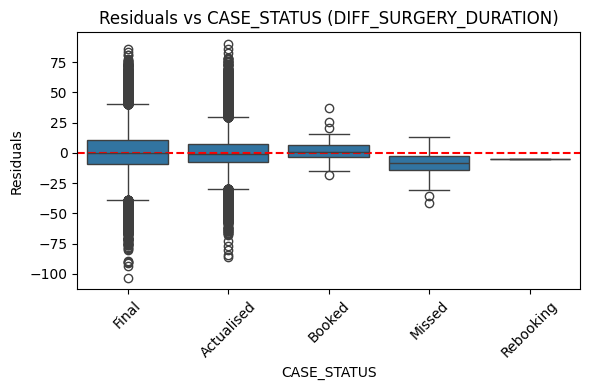

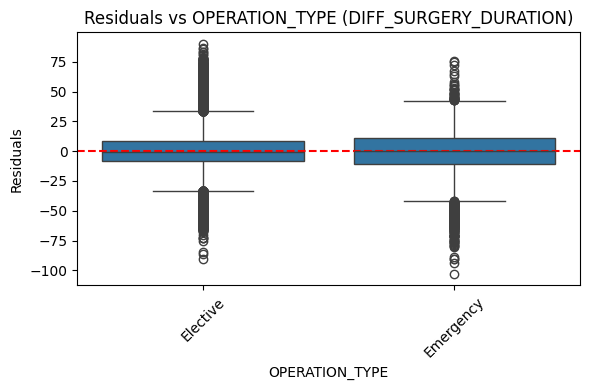

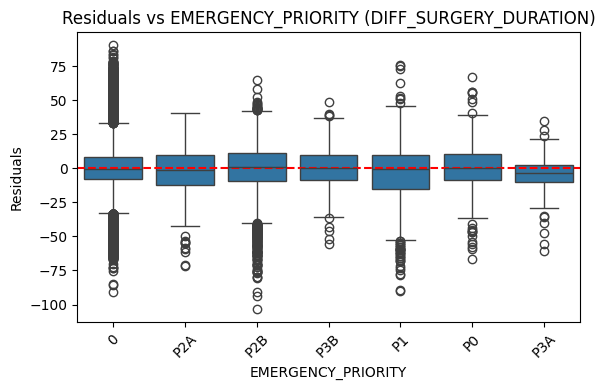

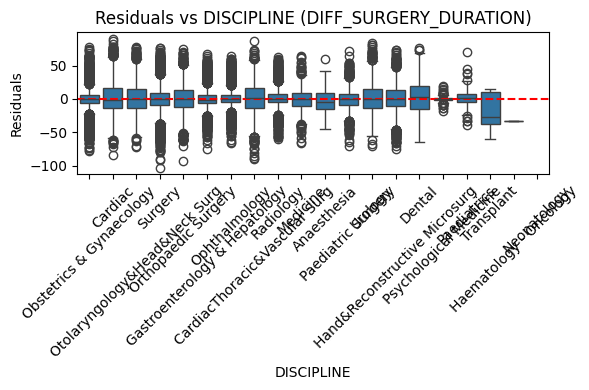

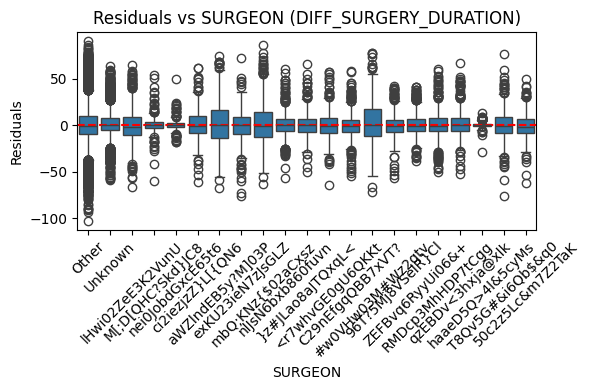

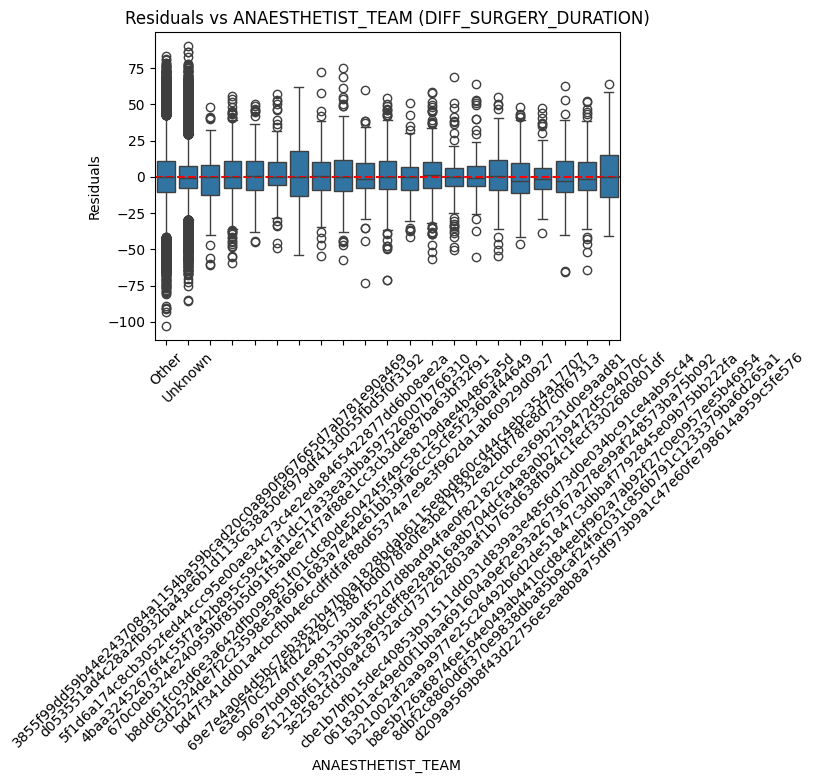

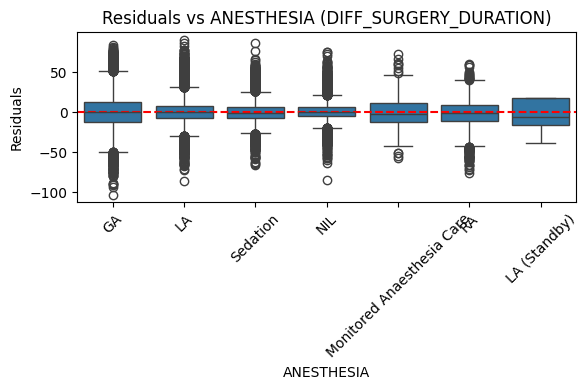

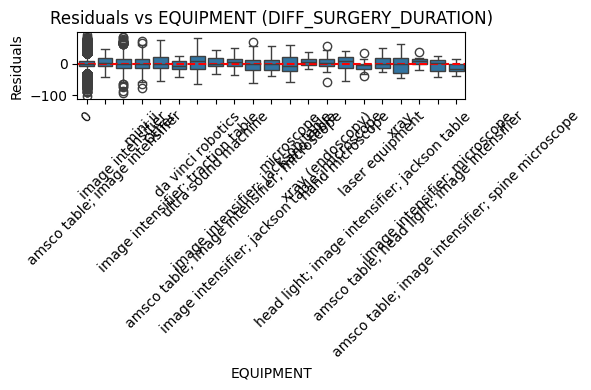

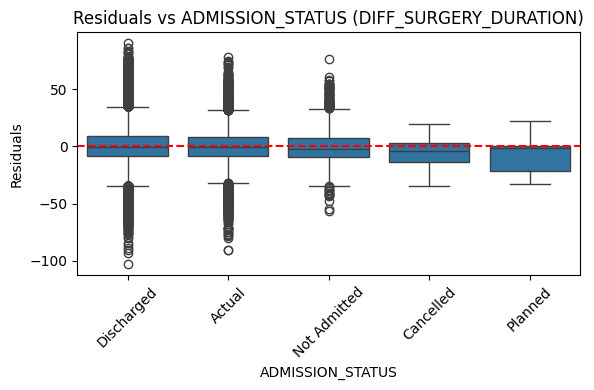

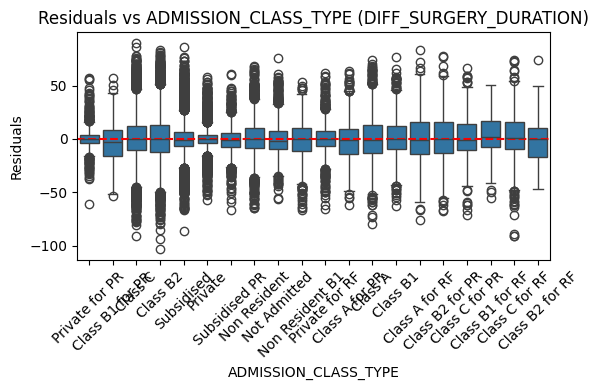

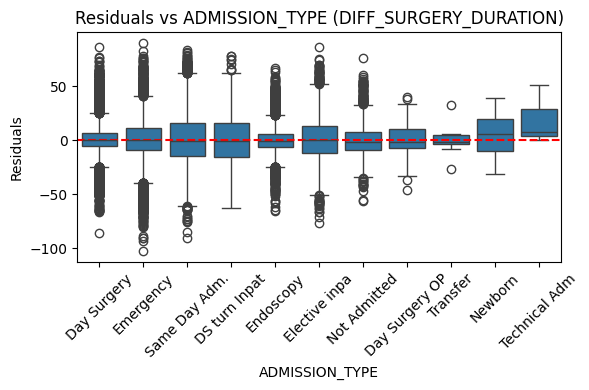

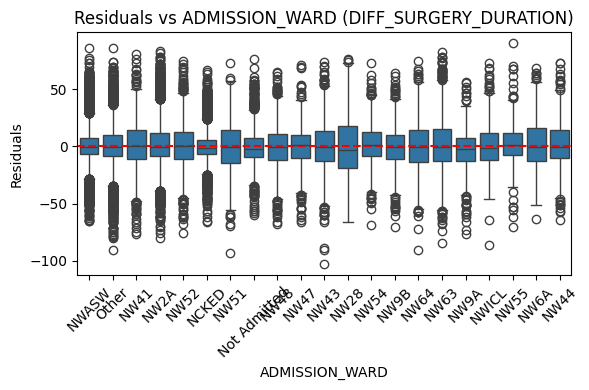

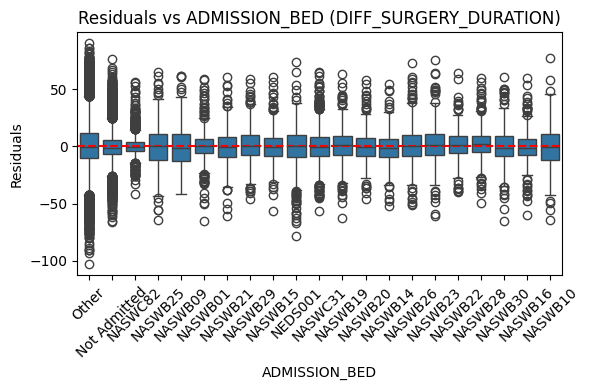

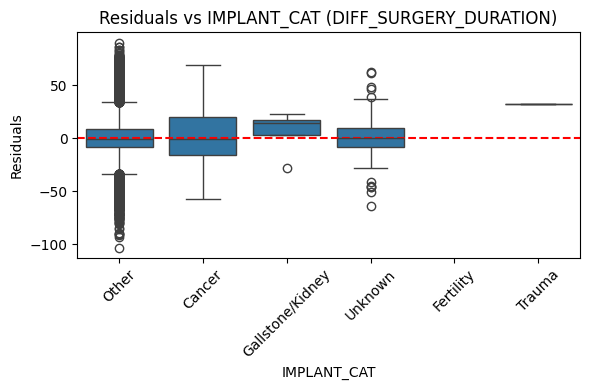

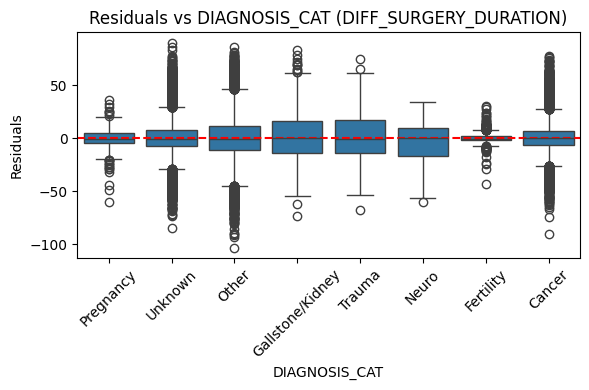

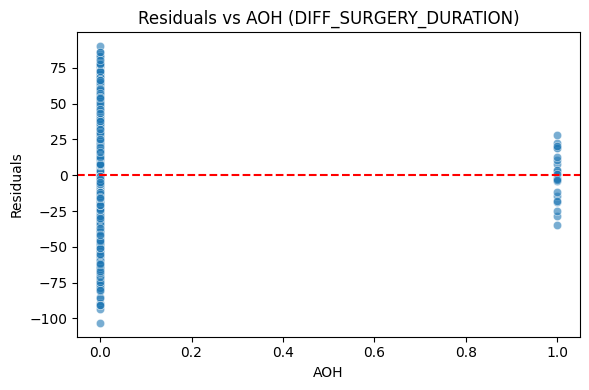

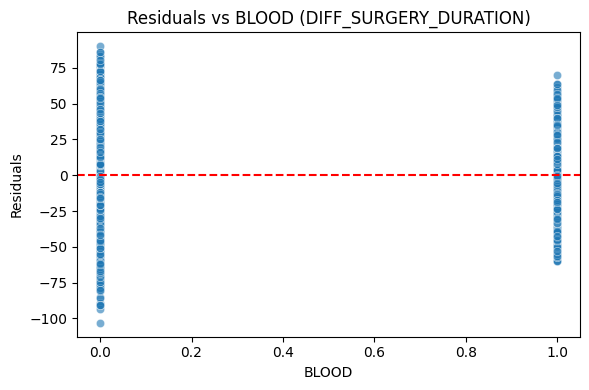

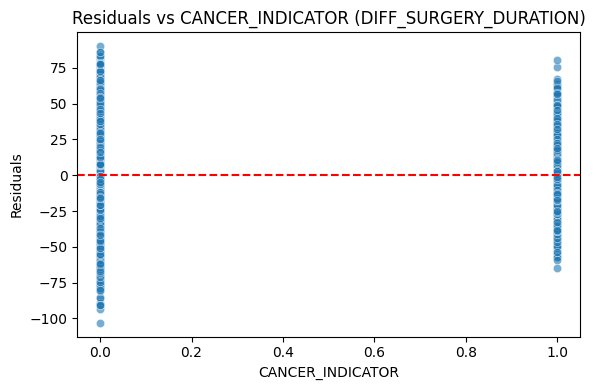

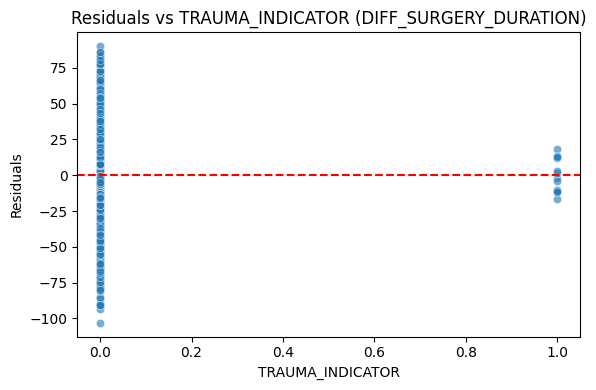

In [9]:
# Dictionary of outcomes and predictions
outcomes = {
    "DIFF_SURGERY_DURATION": (y_test['DIFF_SURGERY_DURATION'], y_pred_surg)
}    

# Loop over all outcomes and predictors
for target_name, (y_true, y_hat) in outcomes.items():
    residuals = y_true - y_hat
    for feature_name in X_raw.columns:
        plot_residuals_vs_feature(X_raw, residuals, feature_name, target_name)

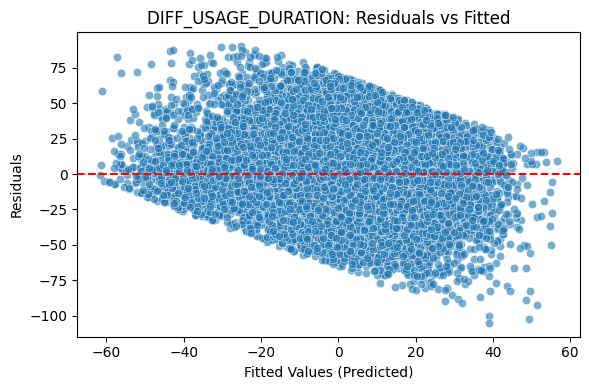

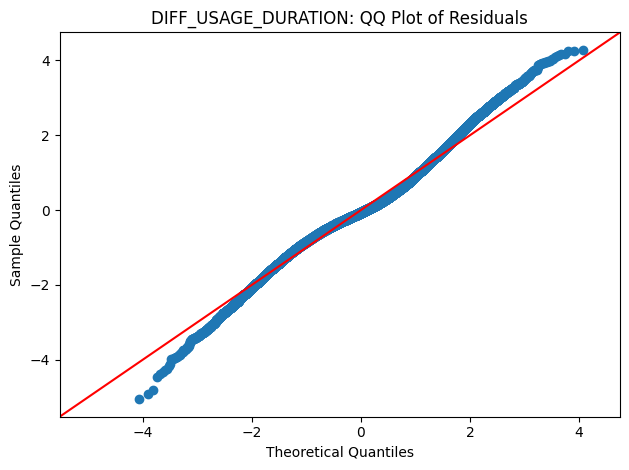

In [10]:
plot_residual_diagnostics(y_test['DIFF_USAGE_DURATION'], y_pred_usage, "DIFF_USAGE_DURATION")

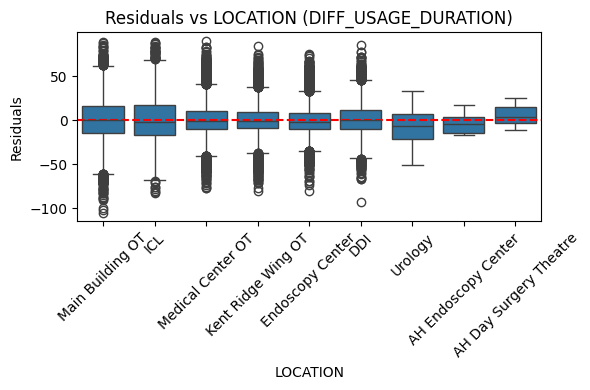

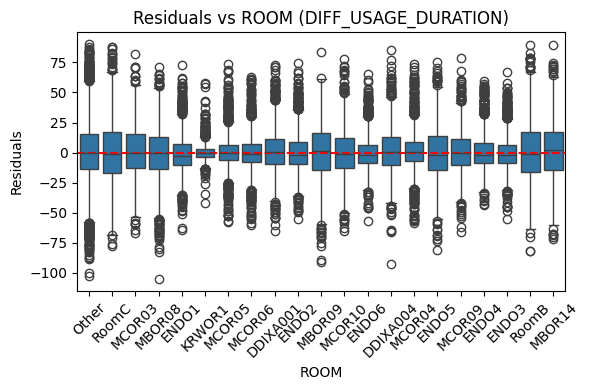

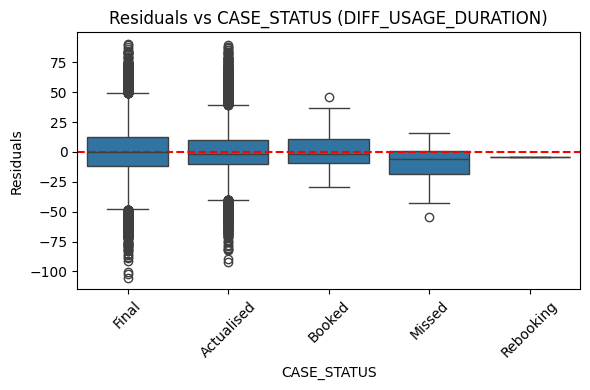

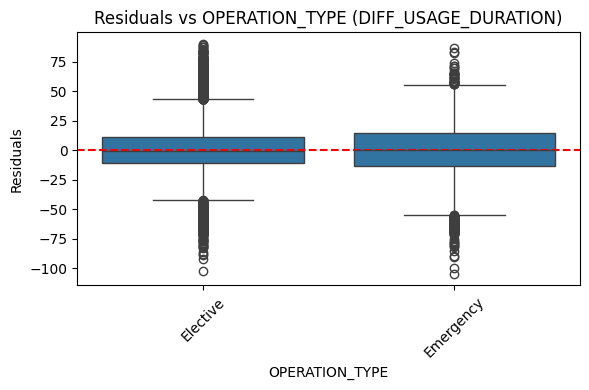

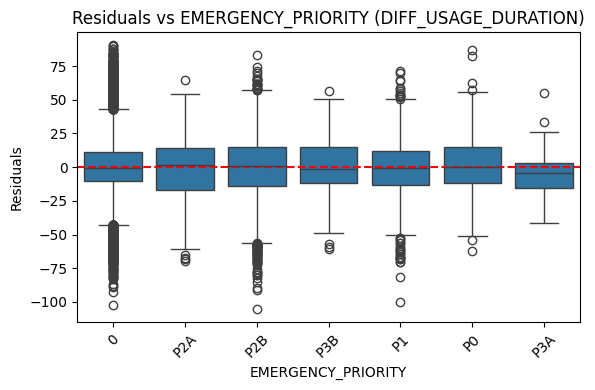

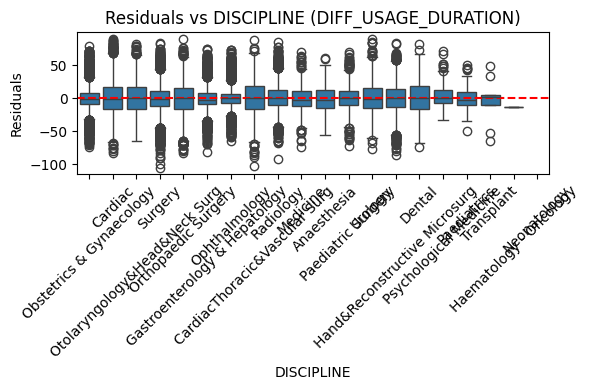

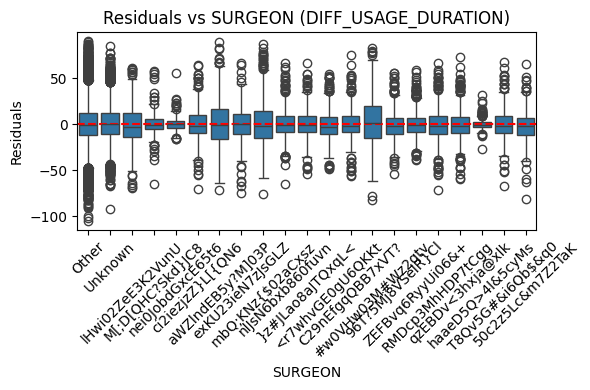

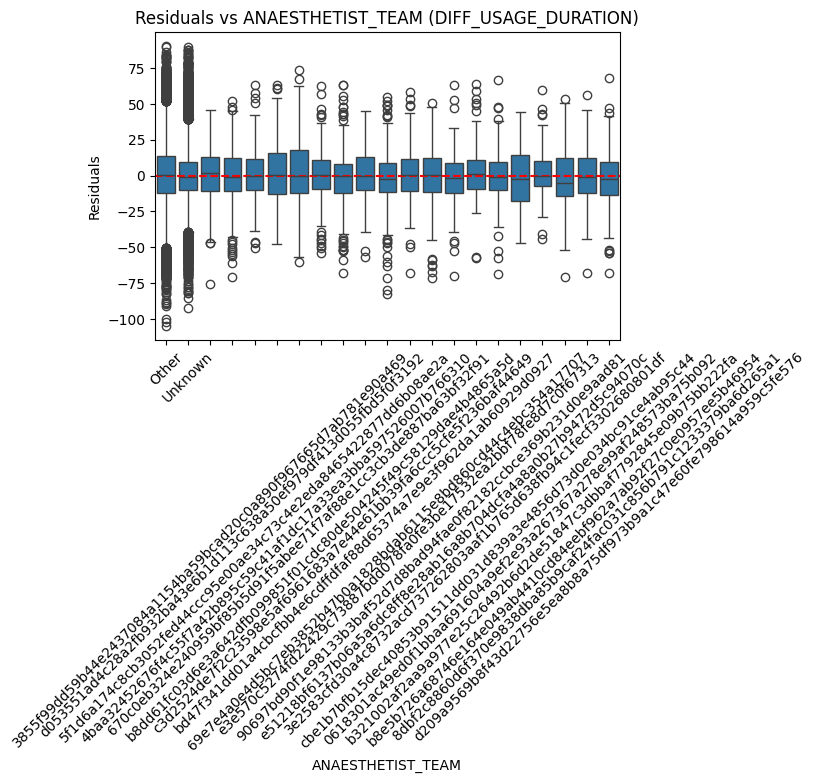

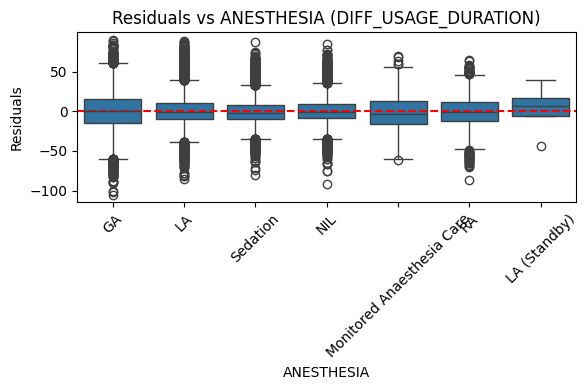

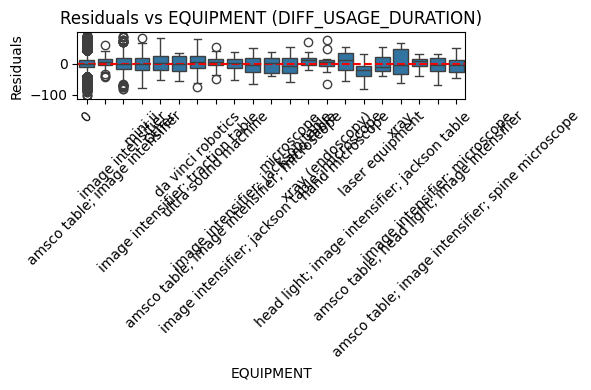

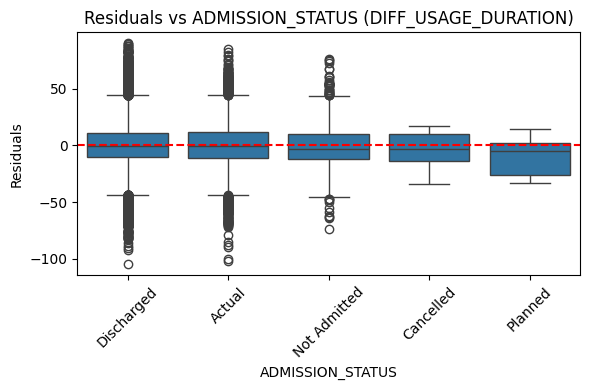

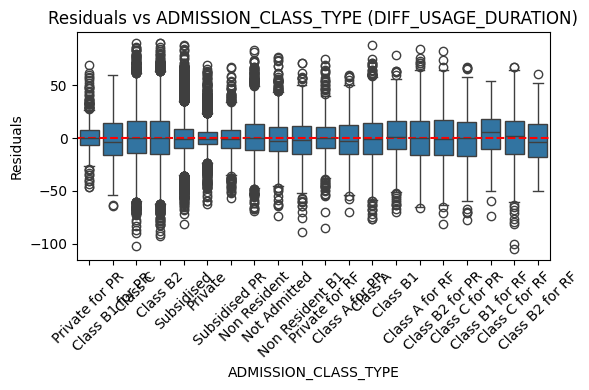

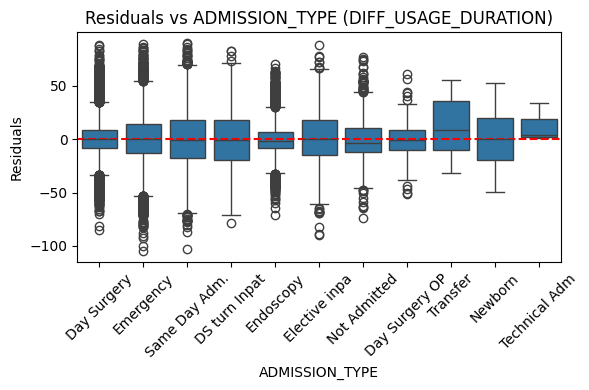

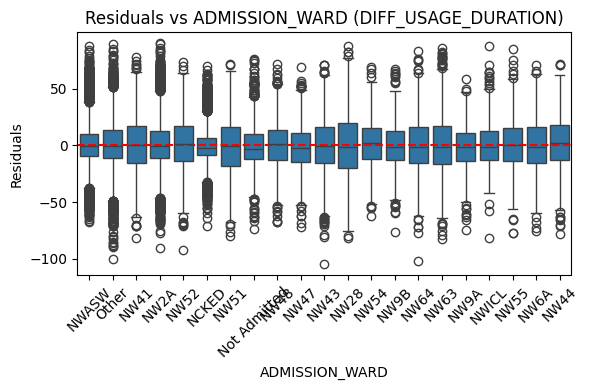

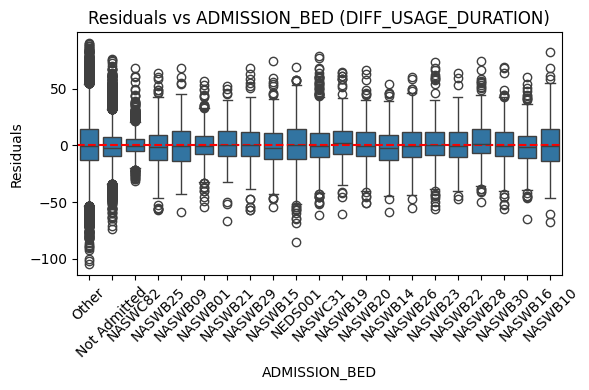

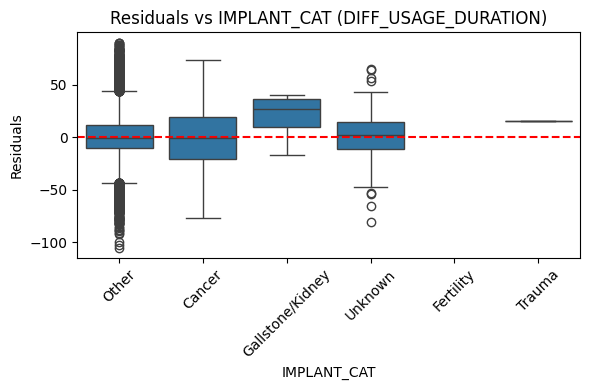

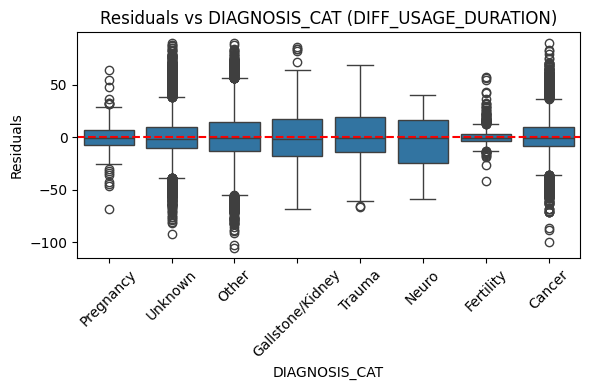

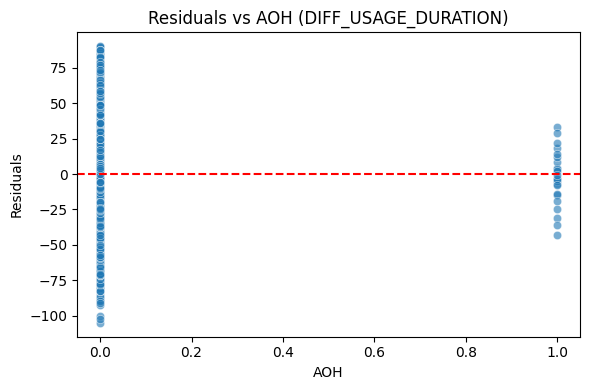

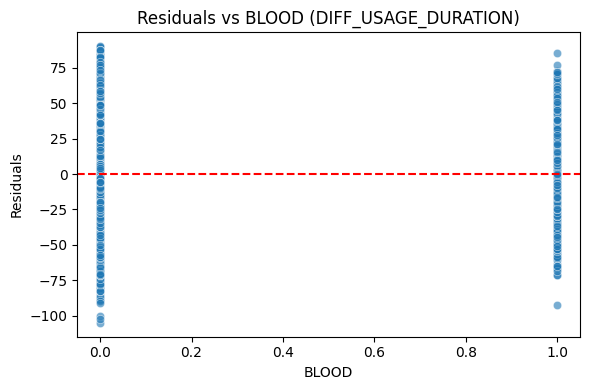

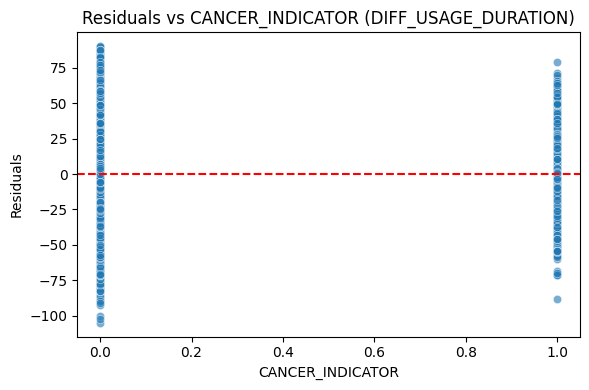

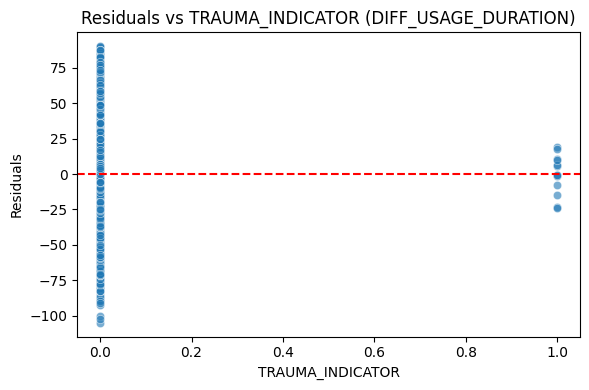

In [11]:
# Dictionary of outcomes and predictions
outcomes = {
    "DIFF_USAGE_DURATION": (y_test['DIFF_USAGE_DURATION'], y_pred_usage)
}

# Loop over all outcomes and predictors
for target_name, (y_true, y_hat) in outcomes.items():
    residuals = y_true - y_hat
    for feature_name in X_raw.columns:
        plot_residuals_vs_feature(X_raw, residuals, feature_name, target_name)